In [1]:
from uninaannpy import neural_network as nn
from uninaannpy import learning_functions as lnf
from uninaannpy import error_functions as errfun
from uninaannpy import activation_functions as actfun
from uninaannpy import datasets as ds

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#Costruzione path del dataset
current_path = os.getcwd()
data_path = os.path.join(current_path, 'data')
train_file_path = os.path.join(data_path, "mnist_train.csv")
test_file_path = os.path.join(data_path, "mnist_test.csv")

#Lettura csv con pandas
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

#Ottenimento array per il training e il testing
train_array = np.array(train_data)
test_array = np.array(test_data)

#Estrapoliamo il numero di righe e di colonne di train e test
train_rows, train_cols = train_array.shape 
test_rows, test_cols = test_array.shape  

#Mescola casualmente i dati prima di suddividerli in set di sviluppo e training
np.random.shuffle(train_array)  
#Calcolo percentuale dati per il validation set
validation_percentage = 0.20
val_index = int(np.ceil(train_rows * validation_percentage))

#Distribuzione training, validation e test set
train_in, train_labels = ds.get_mnist_training(train_array, train_rows, train_cols, val_index)
validation_in, validation_labels = ds.get_mnist_validation(train_array, train_cols, val_index)
test_in, Ytest = ds.get_mnist_testing(test_array, test_cols, test_rows)

#Creazione rete neurale
#Assegnazione funzioni di attivazione per ogni strato della rete
hidden_activation_functions = [actfun.tanh, actfun.relu, actfun.relu, actfun.relu, actfun.relu, actfun.relu, actfun.relu, actfun.relu, actfun.relu, actfun.relu]

#Assegnazione numero di neuroni per ogni strato
hidden_layers = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
#Assegnazione della funzione di attivazione e di errore per l'ultimo strato della rete
output_activation_function = actfun.identity
error_function = errfun.cross_entropy_softmax

#Estrazione input e target
input_layer_size = train_in.shape[0]
output_layer_size = train_labels.shape[0]
net = nn.NeuralNetwork(hidden_activation_functions, output_activation_function, error_function,
                input_layer_size, hidden_layers, output_layer_size)

#Copia la rete principale in una per il training
training_net=lnf.duplicate_network(net)
lnf.get_net_structure(training_net)

Numero di strati nascosti: 10
Dimensione dell'input: 784
Dimensione dell'output: 10
Neuroni negli strati nascosti: 20, 20, 20, 20, 20, 20, 20, 20, 20, 20
Funzioni di attivazione: tanh, tanh, tanh, tanh, tanh, tanh, tanh, tanh, tanh, tanh, identity
Funzione di errore: cross_entropy_softmax


In [2]:
#batch training
train_err, validation_err, train_accuracy, validation_accuracy=lnf.train_neural_network(training_net, train_in, train_labels, validation_in, validation_labels, max_epochs=100, learning_rate=0.00001)


0/100
Training Accuracy: 11.11898%,
Validation Accuracy: 11.70931%

1/100
Training Accuracy: 11.11898%,
Validation Accuracy: 11.70931%

2/100
Training Accuracy: 11.13148%,
Validation Accuracy: 11.76765%

3/100
Training Accuracy: 8.096%,
Validation Accuracy: 7.65064%

4/100
Training Accuracy: 20.78168%,
Validation Accuracy: 20.7434%

5/100
Training Accuracy: 17.94204%,
Validation Accuracy: 18.63489%

6/100
Training Accuracy: 12.49818%,
Validation Accuracy: 12.95941%

7/100
Training Accuracy: 12.87943%,
Validation Accuracy: 12.70939%

8/100
Training Accuracy: 15.06073%,
Validation Accuracy: 14.94291%

9/100
Training Accuracy: 20.7421%,
Validation Accuracy: 21.24344%

10/100
Training Accuracy: 19.4129%,
Validation Accuracy: 19.75165%

11/100
Training Accuracy: 17.94204%,
Validation Accuracy: 18.15151%

12/100
Training Accuracy: 15.57324%,
Validation Accuracy: 15.53463%

13/100
Training Accuracy: 27.19432%,
Validation Accuracy: 27.5773%

14/100
Training Accuracy: 28.63185%,
Validation Acc

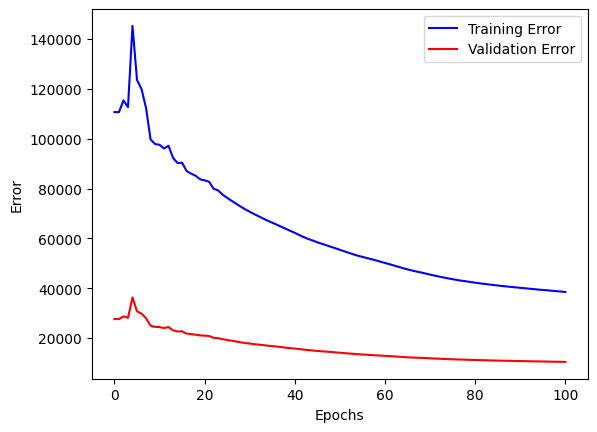

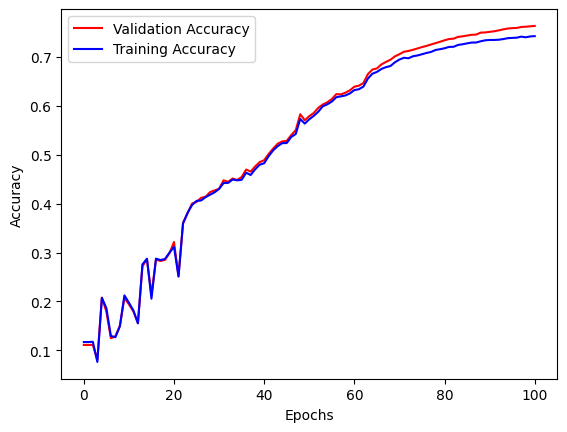

In [3]:
#Stampa grafico dell'errore ottenuto attraverso il training
plt.figure()
plt.plot(train_err, 'b', label='Errori Training')
plt.plot(validation_err, 'r', label='Errori Validation')
plt.xlabel('Epoche')
plt.ylabel('Errori')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracy, 'r', label='Precisione Validation')
plt.plot(validation_accuracy, 'b', label='Precisione Training')
plt.xlabel('Epoche')
plt.ylabel('Precisione')
plt.legend()
plt.show()

In [4]:
#Stampa accuracy per training e test set
test_accuracy = lnf.network_accuracy(training_net, test_in, Ytest)
print('Test accuracy: ', test_accuracy)
accuracy_training = lnf.network_accuracy(training_net, train_in, train_labels)
print('Test accuracy: ', accuracy_training)

Test accuracy:  0.7095541401273885
Test accuracy:  0.7627867247234318


Probabilità predette dalla rete non addestrata:
Classe 0: 9.54172%
Classe 1: 11.35607%
Classe 2: 10.26408%
Classe 3: 9.04068%
Classe 4: 9.91768%
Classe 5: 10.2513%
Classe 6: 10.17486%
Classe 7: 8.73752%
Classe 8: 11.11911%
Classe 9: 9.59698%
Probabilità predette dalla rete addestrata:
Classe 0: 0.99795%
Classe 1: 0.43301%
Classe 2: 6.2015%
Classe 3: 0.79513%
Classe 4: 0.21563%
Classe 5: 0.94391%
Classe 6: 89.41871%
Classe 7: 0.02027%
Classe 8: 0.9725%
Classe 9: 0.00139%


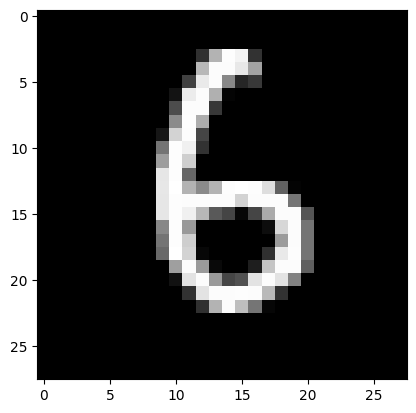

In [8]:
#Predizione rete senza addestramento e rete addestrata
image = 20
lnf.test_prediction(net, training_net, image, test_in)